# Multiscale analysis of SUC2 Invertase in Baker's Yeast

Molecular scale via AlphaFold modeling to show the direct structure of the enzyme.

Reaction scale via Michaelis-Mentin to show the action of the enzyme, and compare the efficiency of mutant strains.

Ecology scale via metabolic modeling through COMETS to help properly convey the impact of the enzyme.

# Molecule Scale

In [3]:
# Imports for AF
from Bio.PDB import *
import nglview as nv
import ipywidgets

## AlphaFold Model

In [2]:
pdb_parser = PDBParser()
structure = pdb_parser.get_structure("P", "SUC2_Invertase.pdb")
view = nv.show_biopython(structure)
view

NGLWidget()

# Reaction Scale

In [1]:
# Imports for M-M
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

## Michaelis-Mentin
Perhaps Compare Mutants

# Ecology Scale

In [11]:
# Imports for COMETS
import cometspy as cp
import cobra as cb
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import matplotlib.colors as clrs
import os

In [12]:
# set Gurobi environment variable to the gurobi install location on your computer
os.environ['GUROBI_HOME'] = 'C:\Program Files\gurobi1001\win64'
os.environ['COMETS_HOME'] = 'C:\Program Files\comets'

## Metabolic Modeling (COMETS)
http://bigg.ucsd.edu/models/iMM904

In [5]:
# Load model
model = cb.io.read_sbml_model('iMM904.xml')

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-16


In [6]:
# turn off all exchange reactions
for ex in model.exchanges:
    ex.lower_bound = 0.
    ex.upper_bound = 1000.

In [80]:
# Define Media
# Define Base Media
# Structure ['exchange ID',concentration(mmols)]
# minimal media (look up BiGG Metabolites to find more info on IDs) (No Carbon Source)
min_med = [['EX_h2o_e',1000.],#aerobic base
           ['EX_h_e',1000.],
           ['EX_co2_e',1000.],
           ['EX_fe2_e',1000.],#metals
           ['EX_k_e',1000.],
           ['EX_na1_e',1000.],
           ['EX_pi_e',1000.],#phosphorus source
           ['EX_so4_e',1000.],#sulfer source
           ['EX_nh4_e',1000.]]#nitrogen source
# Define Additional Media Components
glucose = [['EX_glc__D_e',10]]# carbon source
fructose = [['EX_fru_e', 10]] # Secondary carbon source
sucrose = [['EX_sucr_e',30]] # Tertiary Carbon Source
oxygen = [['EX_o2_e',1000.]] # Plentiful 02

vol = 0.1

In [81]:
# Create COMETS model from COBRA model
model.id = "model"
model_comets = cp.model(model)

# set initial population
initial_pop = 1.e-3 #gDW
model_comets.initial_pop = [0,0,initial_pop]

# open exchange reactions
model_comets.open_exchanges()

# Set the optimization method
model_comets.obj_style = "MAX_OBJECTIVE_MIN_TOTAL"

# Set Params
params = cp.params()

# Adjust Params
params.set_param("spaceWidth",vol**(1/3))
params.set_param("defaultVmax",10.)
params.set_param("defaultKm",0.01)

# Set timestep
t_step = 0.1
t_total = 200

params.set_param("timeStep",t_step) #hours
params.set_param("maxSpaceBiomass",10.) #max grams of biomass in a box
params.set_param("maxCycles",t_total)
params.set_param("writeMediaLog", True)
params.set_param("MediaLogRate", 1)
params.set_param("writeFluxLog", True)
params.set_param("FluxLogRate", 1)


In [97]:
# Create Layout and Run
# Create the layout
layout_glc = cp.layout([model_comets])

# Specify metabolites in layout
# minimal medium + glucose
tmp_medium = min_med + sucrose + oxygen + glucose + fructose

for component in tmp_medium:
    met = component[0][3:]
    c = component[1]
    mmol = c*vol
    layout_glc.set_specific_metabolite(met,mmol)
    
# Create comets object
sim = cp.comets(layout_glc, params)

# Run Simulation
sim.run()


Running COMETS simulation ...


C:\Users\NBosl\anaconda3\envs\CSBfinal\lib\site-packages\cometspy\model.py:973: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  smat.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
C:\Users\NBosl\anaconda3\envs\CSBfinal\lib\site-packages\cometspy\model.py:979: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  bnd.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
C:\Users\NBosl\anaconda3\envs\CSBfinal\lib\site-packages\cometspy\model.py:987: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  met_n.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
C:\Users\NBosl\anaconda3\envs\CSBfinal\lib\site-packages\cometspy\model.py:991: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  rxn_n.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)


Done!


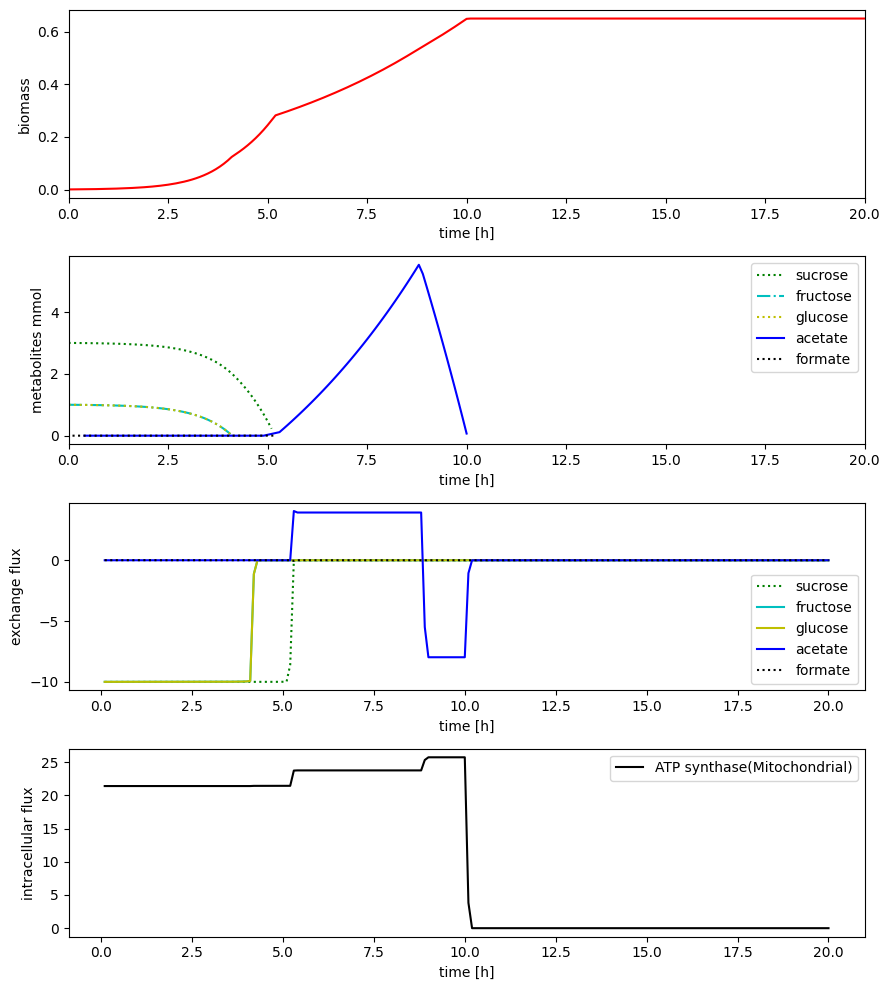

In [98]:
# Plotting
[fig,axs]=plt.subplots(4,1,figsize=[9,10])
t_array = np.arange(0,(t_total+t_step/2)*t_step,t_step)

# Plot Biomass
biomass_glc = np.array(sim.total_biomass.model)
axs[0].plot(t_array,biomass_glc,'r-')
axs[0].set_xlabel('time [h]')
axs[0].set_ylabel('biomass');
axs[0].set_xlim(0,20)

# Plot metabolites
md = sim.media

# Maybe in no O2
# axs[1].plot(t_array[md.loc[md['metabolite']=='lac__L_e'].cycle.values],md.loc[md['metabolite']=='lac__L_e'].conc_mmol.values)#Lactate

axs[1].plot(t_array[md.loc[md['metabolite']=='sucr_e'].cycle.values],md.loc[md['metabolite']=='sucr_e'].conc_mmol.values,'g:')#sucrose
axs[1].plot(t_array[md.loc[md['metabolite']=='fru_e'].cycle.values],md.loc[md['metabolite']=='fru_e'].conc_mmol.values,'c-.')#fructose
axs[1].plot(t_array[md.loc[md['metabolite']=='glc__D_e'].cycle.values],md.loc[md['metabolite']=='glc__D_e'].conc_mmol.values,'y:')#glucose
axs[1].plot(t_array[md.loc[md['metabolite']=='ac_e'].cycle.values],md.loc[md['metabolite']=='ac_e'].conc_mmol.values,'b') #acetate
axs[1].plot(t_array[md.loc[md['metabolite']=='for_e'].cycle.values],md.loc[md['metabolite']=='for_e'].conc_mmol.values,'k:') #formate

axs[1].set_ylabel('metabolites mmol')
axs[1].set_xlabel('time [h]')
axs[1].set_xlim(0,20)
axs[1].legend(['sucrose', 'fructose','glucose','acetate','formate'])

# Plot Exchange Fluxes
r = 'EX_sucr_e'
flx_r = np.zeros(200)
for i in range(200):
    flx_r[i] = sim.get_flux_image(model_id = 'model', reaction_id = r, cycle = i+1)[0][0]
axs[2].plot(t_array[1:],flx_r,'g:')
r = 'EX_fru_e'
flx_r = np.zeros(200)
for i in range(200):
    flx_r[i] = sim.get_flux_image(model_id = 'model', reaction_id = r, cycle = i+1)[0][0]
axs[2].plot(t_array[1:],flx_r,'c')
r = 'EX_glc__D_e'
flx_r = np.zeros(200)
for i in range(200):
    flx_r[i] = sim.get_flux_image(model_id = 'model', reaction_id = r, cycle = i+1)[0][0]
axs[2].plot(t_array[1:],flx_r,'y')
r = 'EX_ac_e'
flx_r = np.zeros(200)
for i in range(200):
    flx_r[i] = sim.get_flux_image(model_id = 'model', reaction_id = r, cycle = i+1)[0][0]
axs[2].plot(t_array[1:],flx_r,'b')
r = 'EX_for_e'
flx_r = np.zeros(200)
for i in range(200):
    flx_r[i] = sim.get_flux_image(model_id = 'model', reaction_id = r, cycle = i+1)[0][0]
axs[2].plot(t_array[1:],flx_r,'k:')

axs[2].legend(['sucrose', 'fructose', 'glucose','acetate','formate'])
axs[2].set_ylabel('exchange flux')
axs[2].set_xlabel('time [h]')
    
#intracellular fluxes

# Mitochondria
r = 'ATPS3m'
flx_r = np.zeros(200)
for i in range(200):
    flx_r[i] = sim.get_flux_image(model_id = 'model', reaction_id = r, cycle = i+1)[0][0]
axs[3].plot(t_array[1:],flx_r,'k')


# Other, insignificant ATP synthases:

# Golgi 
# r = 'ATPS3g'
# flx_r = np.zeros(200)
# for i in range(200):
#     flx_r[i] = sim.get_flux_image(model_id = 'model', reaction_id = r, cycle = i+1)[0][0]
# axs[3].plot(t_array[1:],flx_r,'r')

# Vacuole
# r = 'ATPS3v'
# flx_r = np.zeros(200)
# for i in range(200):
#     flx_r[i] = sim.get_flux_image(model_id = 'model', reaction_id = r, cycle = i+1)[0][0]
# axs[3].plot(t_array[1:],flx_r,'g')

axs[3].set_ylabel('intracellular flux')
axs[3].set_xlabel('time [h]')
axs[3].legend(['ATP synthase(Mitochondrial)'])
    
fig.tight_layout()

### Now for a simulation without oxygen

In [77]:
# Create COMETS model from COBRA model
model.id = "model"
model_comets = cp.model(model)

# set initial population
initial_pop = 1.e-1 #gDW
model_comets.initial_pop = [0,0,initial_pop]

# open exchange reactions
model_comets.open_exchanges()

# Set the optimization method
model_comets.obj_style = "MAX_OBJECTIVE_MIN_TOTAL"

# Set Params
params = cp.params()

# Adjust Params
params.set_param("spaceWidth",vol**(1/3))
params.set_param("defaultVmax",10.)
params.set_param("defaultKm",0.01)

# Set timestep
t_step = 0.1
t_total = 200

params.set_param("timeStep",t_step) #hours
params.set_param("maxSpaceBiomass",10.) #max grams of biomass in a box
params.set_param("maxCycles",t_total)
params.set_param("writeMediaLog", True)
params.set_param("MediaLogRate", 1)
params.set_param("writeFluxLog", True)
params.set_param("FluxLogRate", 1)


In [78]:
# Create Layout and Run
# Create the layout
layout_glc = cp.layout([model_comets])

# Specify metabolites in layout
# minimal medium + glucose
tmp_medium = min_med + glucose + fructose + sucrose

for component in tmp_medium:
    met = component[0][3:]
    c = component[1]
    mmol = c*vol
    layout_glc.set_specific_metabolite(met,mmol)
    
# Create comets object
sim = cp.comets(layout_glc, params)

# Run Simulation
sim.run()


Running COMETS simulation ...


C:\Users\NBosl\anaconda3\envs\CSBfinal\lib\site-packages\cometspy\model.py:973: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  smat.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
C:\Users\NBosl\anaconda3\envs\CSBfinal\lib\site-packages\cometspy\model.py:979: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  bnd.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
C:\Users\NBosl\anaconda3\envs\CSBfinal\lib\site-packages\cometspy\model.py:987: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  met_n.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
C:\Users\NBosl\anaconda3\envs\CSBfinal\lib\site-packages\cometspy\model.py:991: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  rxn_n.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)


Done!


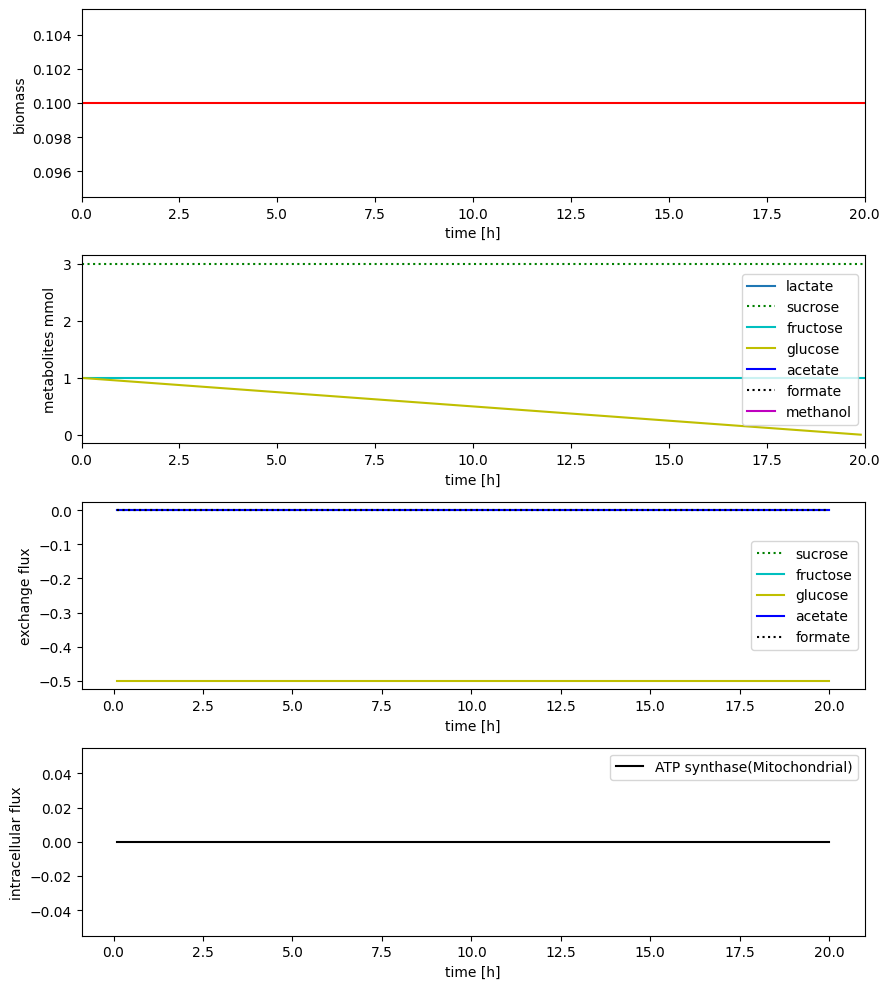

In [79]:
# Plotting
[fig,axs]=plt.subplots(4,1,figsize=[9,10])
t_array = np.arange(0,(t_total+t_step/2)*t_step,t_step)

# Plot Biomass
biomass_glc = np.array(sim.total_biomass.model)
axs[0].plot(t_array,biomass_glc,'r-')
axs[0].set_xlabel('time [h]')
axs[0].set_ylabel('biomass');
axs[0].set_xlim(0,20)

# Plot metabolites
md = sim.media

# Maybe in no O2
axs[1].plot(t_array[md.loc[md['metabolite']=='lac__L_e'].cycle.values],md.loc[md['metabolite']=='lac__L_e'].conc_mmol.values)#Lactate

axs[1].plot(t_array[md.loc[md['metabolite']=='sucr_e'].cycle.values],md.loc[md['metabolite']=='sucr_e'].conc_mmol.values,'g:')#sucrose
axs[1].plot(t_array[md.loc[md['metabolite']=='fru_e'].cycle.values],md.loc[md['metabolite']=='fru_e'].conc_mmol.values,'c')#sucrose
axs[1].plot(t_array[md.loc[md['metabolite']=='glc__D_e'].cycle.values],md.loc[md['metabolite']=='glc__D_e'].conc_mmol.values,'y')#glucose
axs[1].plot(t_array[md.loc[md['metabolite']=='ac_e'].cycle.values],md.loc[md['metabolite']=='ac_e'].conc_mmol.values,'b') #acetate
axs[1].plot(t_array[md.loc[md['metabolite']=='for_e'].cycle.values],md.loc[md['metabolite']=='for_e'].conc_mmol.values,'k:') #formate

axs[1].set_ylabel('metabolites mmol')
axs[1].set_xlabel('time [h]')
axs[1].set_xlim(0,20)
axs[1].legend(['lactate','sucrose', 'fructose','glucose','acetate','formate'])

# Plot Exchange Fluxes
r = 'EX_sucr_e'
flx_r = np.zeros(200)
for i in range(200):
    flx_r[i] = sim.get_flux_image(model_id = 'model', reaction_id = r, cycle = i+1)[0][0]
axs[2].plot(t_array[1:],flx_r,'g:')
r = 'EX_fru_e'
flx_r = np.zeros(200)
for i in range(200):
    flx_r[i] = sim.get_flux_image(model_id = 'model', reaction_id = r, cycle = i+1)[0][0]
axs[2].plot(t_array[1:],flx_r,'c')
r = 'EX_glc__D_e'
flx_r = np.zeros(200)
for i in range(200):
    flx_r[i] = sim.get_flux_image(model_id = 'model', reaction_id = r, cycle = i+1)[0][0]
axs[2].plot(t_array[1:],flx_r,'y')
r = 'EX_ac_e'
flx_r = np.zeros(200)
for i in range(200):
    flx_r[i] = sim.get_flux_image(model_id = 'model', reaction_id = r, cycle = i+1)[0][0]
axs[2].plot(t_array[1:],flx_r,'b')
r = 'EX_for_e'
flx_r = np.zeros(200)
for i in range(200):
    flx_r[i] = sim.get_flux_image(model_id = 'model', reaction_id = r, cycle = i+1)[0][0]
axs[2].plot(t_array[1:],flx_r,'k:')

axs[2].legend(['sucrose', 'fructose', 'glucose','acetate','formate'])
axs[2].set_ylabel('exchange flux')
axs[2].set_xlabel('time [h]')
    
#intracellular fluxes

# Mitochondria
r = 'ATPS3m'
flx_r = np.zeros(200)
for i in range(200):
    flx_r[i] = sim.get_flux_image(model_id = 'model', reaction_id = r, cycle = i+1)[0][0]
axs[3].plot(t_array[1:],flx_r,'k')


# Other, insignificant ATP synthases:

# Golgi 
# r = 'ATPS3g'
# flx_r = np.zeros(200)
# for i in range(200):
#     flx_r[i] = sim.get_flux_image(model_id = 'model', reaction_id = r, cycle = i+1)[0][0]
# axs[3].plot(t_array[1:],flx_r,'r')

# Vacuole
# r = 'ATPS3v'
# flx_r = np.zeros(200)
# for i in range(200):
#     flx_r[i] = sim.get_flux_image(model_id = 'model', reaction_id = r, cycle = i+1)[0][0]
# axs[3].plot(t_array[1:],flx_r,'g')

axs[3].set_ylabel('intracellular flux')
axs[3].set_xlabel('time [h]')
axs[3].legend(['ATP synthase(Mitochondrial)'])
    
fig.tight_layout()